In [73]:
import cv2 
import os
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import numpy.matlib
import warnings
warnings.filterwarnings("ignore")
import time
import glob
import PIL
import pandas as pd

In [74]:
class CameraRespFunct:
    def __init__(self, path, l, exposureTimes):
        ''' 
        Inputs: 
            path(str): path to folder with images
            l(float): smoothing factor, lambda
            exposureTimes(list): list of exposure times for image array
        '''  

        self.images = self.create_imgArr(path)                          # self.images = image array
        self.times = np.array(exposureTimes, dtype=np.float32)          # self.times = exposure times array

        self.N = len(self.images)                                       # self.N = number of images
        self.H = len(self.images[0])                                    # self.H = height of images (pixels)
        self.W = len(self.images[0][0])                                 # self.W = width of images (pixels)
         
        self.l = l                                                      # self.l = smoothing factor, lambda
        self.Bj = np.log(self.times)                                    # self.Bj = log of exposure times

        alignMTB = cv2.createAlignMTB()
        alignMTB.process(self.images, self.images)
    
    def create_imgArr(self, path):
        
        image_list = [] 
        
        for i, filename in enumerate(glob.glob(path + "\\" + '*.jpg')): 
            im = cv2.imread(path + '\\' + str(i) + '.jpg')
            image_list.append(im)
        
        return image_list
          
    def display_OriginalImages(self,figureSize):
        offset = 50    
        Canvas = np.ones((self.H, (self.W+offset)*self.N,3),dtype=np.float32)
               
        for l in range(self.N):
            c1 = l*(self.W+offset)
            c2 = c1 + self.W
            Canvas[0:self.H, c1:c2,:] = (self.images[l]/255).astype(np.float32)
 
        fig = plt.figure(constrained_layout=False,figsize=figureSize)
        plt.imshow(cv2.cvtColor(Canvas[:,:c2,:],cv2.COLOR_BGR2RGB))
        plt.title("underexposed  <---    Original images    --->   overexposed", fontsize=20)
        plt.xticks([])
        plt.yticks([])
        
    def w_funct(self, z):
        Zmin = 0 
        Zmax = 255 
        Zmid = (Zmax+Zmin)//2
        
        if isinstance(z, np.ndarray):
            w = np.zeros_like(z)
            for i, z_val in enumerate(z):
                if z_val <= Zmid:
                    w[i] = (z_val - Zmin + 1)
                else: 
                    w[i] = (Zmax - z_val + 1)
            
            return w

        else:
            if z <= Zmid:
                return  (z - Zmin + 1)
            else: 
                return  (Zmax - z + 1)

 
        
    def getSamples(self):
    
        numPixels = self.H * self.W
        numSamples = 50

        stepSize = int(np.floor(numPixels / numSamples))

        samplePixels = np.arange(0,numPixels,stepSize)[:numSamples]
        
        # get flatten image 
        self.flattenedImages = np.zeros((self.N, 3, numPixels),dtype=np.uint8)
        for n in range(self.N):
            for c in range(3):
                self.flattenedImages[n,c] = self.images[n][:,:,c].flatten()
        
        # set arrays to store pixel values at sampled locations 
        self.ZR = np.zeros((numSamples,self.N) ,dtype=np.uint8)
        self.ZG = np.zeros((numSamples,self.N,),dtype=np.uint8)
        self.ZB = np.zeros((numSamples,self.N) ,dtype=np.uint8)
    
    
        # get the sampled pixel values 
        for n in range(self.N):            
            self.ZR[:,n] = self.flattenedImages[n,0][samplePixels]
            self.ZG[:,n] = self.flattenedImages[n,1][samplePixels]
            self.ZB[:,n] = self.flattenedImages[n,2][samplePixels]
           

    def gsolve(self,Z):
        # this function is a python version of the one provided by Debevec's paper. 
        '''        
        solve for imaging system response function 

        Given a set of pixel values observed for several pixels 
        in several images with different exposure times, 

        this funcction returns the imaging system's response function g as well as the log film irradiance values 
        for the observed pixels 


        Inputs: 
        Z(i,j) : pixel values of pixel locations number i in image j 
        B(j)   : the log delta t for image j
        l   : lambda, the constant that determines the amount of smoothness
        w(z): the weighting function value for pixel value z 

        outputs:
        g(z) : log exposure corresponding to pixel value z 
        lE(i): the log film irradiance at pixel location i 
        '''

        n = 256

        s1, s2 = Z.shape
        A = np.zeros((s1*s2+n+1, n+s1))
        b = np.zeros((A.shape[0],1))

        ## include the data-fitting equations 
        k=0
        for i in range(s1):
            for j in range(s2):
                wij = self.w_funct(Z[i,j])
                A[k,Z[i,j]] = wij
                A[k,n+i] = -wij
                b[k] = wij*self.Bj[j]
                k +=1

        # fix the curve by setting its middle value to zero     
        A[k,129] = 0
        k +=1
    
        # include the smoothness equations 
        for i in range(1,n-2):
            A[k,i] = self.l*self.w_funct(i+1)
            A[k,i+1] = -2*self.l*self.w_funct(i+1)
            A[k,i+2] = self.l*self.w_funct(i+1)
            k +=1
        
        # solve the system using Singular Value Decomposition(SVD)
        x = np.linalg.lstsq(A,b,rcond=None) 
        
        x = x[0]
        g = x[:n].flatten()
        lE = x[n:].flatten()    
        
        return g, lE
        
    def plotResponseCurves(self, axs, r, c): 

        px = list(range(0,256))
        axs[r,c].set_title(f"Response curves for RGB, lambda = {self.l}")
        axs[r,c].plot(px,np.exp(self.gR),'r')
        axs[r,c].plot(px,np.exp(self.gB),'b')
        axs[r,c].plot(px,np.exp(self.gG),'g')
        axs[r,c].set_ylabel("log Exposure X")
        axs[r,c].set_xlabel("Pixel value Z")
    
    def getCameraResp(self):

        self.getSamples()
        
        self.gR, self.lER = self.gsolve(self.ZR)
        self.gG, self.lEG = self.gsolve(self.ZG)
        self.gB, self.lEB = self.gsolve(self.ZB)

        gList = [self.gR, self.gG, self.gB]
        lEList = [self.lER, self.lEG, self.lEB]

        return gList, lEList
    
    def recover_HDR_RadianceMap(self):
        m = np.zeros((self.flattenedImages.shape[1:]))
        wsum = np.zeros(self.flattenedImages.shape[1:])
        hdr = np.zeros(self.flattenedImages.shape[1:])
        
        lnDt = np.log(self.times)

        for i in range(self.N):

            wij_B = self.w_funct(self.flattenedImages[i,2])
            wij_G = self.w_funct(self.flattenedImages[i,1])
            wij_R = self.w_funct(self.flattenedImages[i,0])
            
            wsum[2,:] += wij_B
            wsum[1,:] += wij_G
            wsum[0,:] += wij_R
            
            m2 = np.subtract(self.gB[self.flattenedImages[i,2]],lnDt[i])
            m1 = np.subtract(self.gG[self.flattenedImages[i,1]],lnDt[i])
            m0 = np.subtract(self.gR[self.flattenedImages[i,0]],lnDt[i])
    
            hdr[2] = hdr[2] + np.multiply(m0,wij_B)
            hdr[1] = hdr[1] + np.multiply(m1,wij_G)
            hdr[0] = hdr[0] + np.multiply(m2,wij_R)

        hdr = np.divide(hdr,wsum)
        hdr = np.exp(hdr)
        hdr = np.reshape(np.transpose(hdr), (self.H,self.W,3))
                    
        self.imgf32 = (hdr/np.amax(hdr)*255).astype(np.float32)
        plt.figure(constrained_layout=False,figsize=(10,10))
        plt.title("fused HDR radiance map", fontsize=20)
        plt.imshow(self.imgf32)        

        

    def tone_mapping(self):
        # Tonemap using Drago's method to obtain 24-bit color image
        tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
        ldrDrago = tonemapDrago.process(self.imgf32)
        ldrDrago = 3 * ldrDrago
        cv2.imwrite("ldr-Drago-2.jpg", ldrDrago * 255)
        fig = plt.figure(constrained_layout=False,figsize=(10,10))
        plt.title("Tone-mapped image", fontsize=20)
        plt.imshow(ldrDrago)
    



#### Get Camera Response Function of iPhone

In [75]:
path = r"C:\Users\tranl\Documents\Stanford\Winter 2024\EE 367\EE367_FinalProject\new_images"
lambdas = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
exposures = [1/1, 1/5, 1/13, 1/25, 1/60, 1/100]


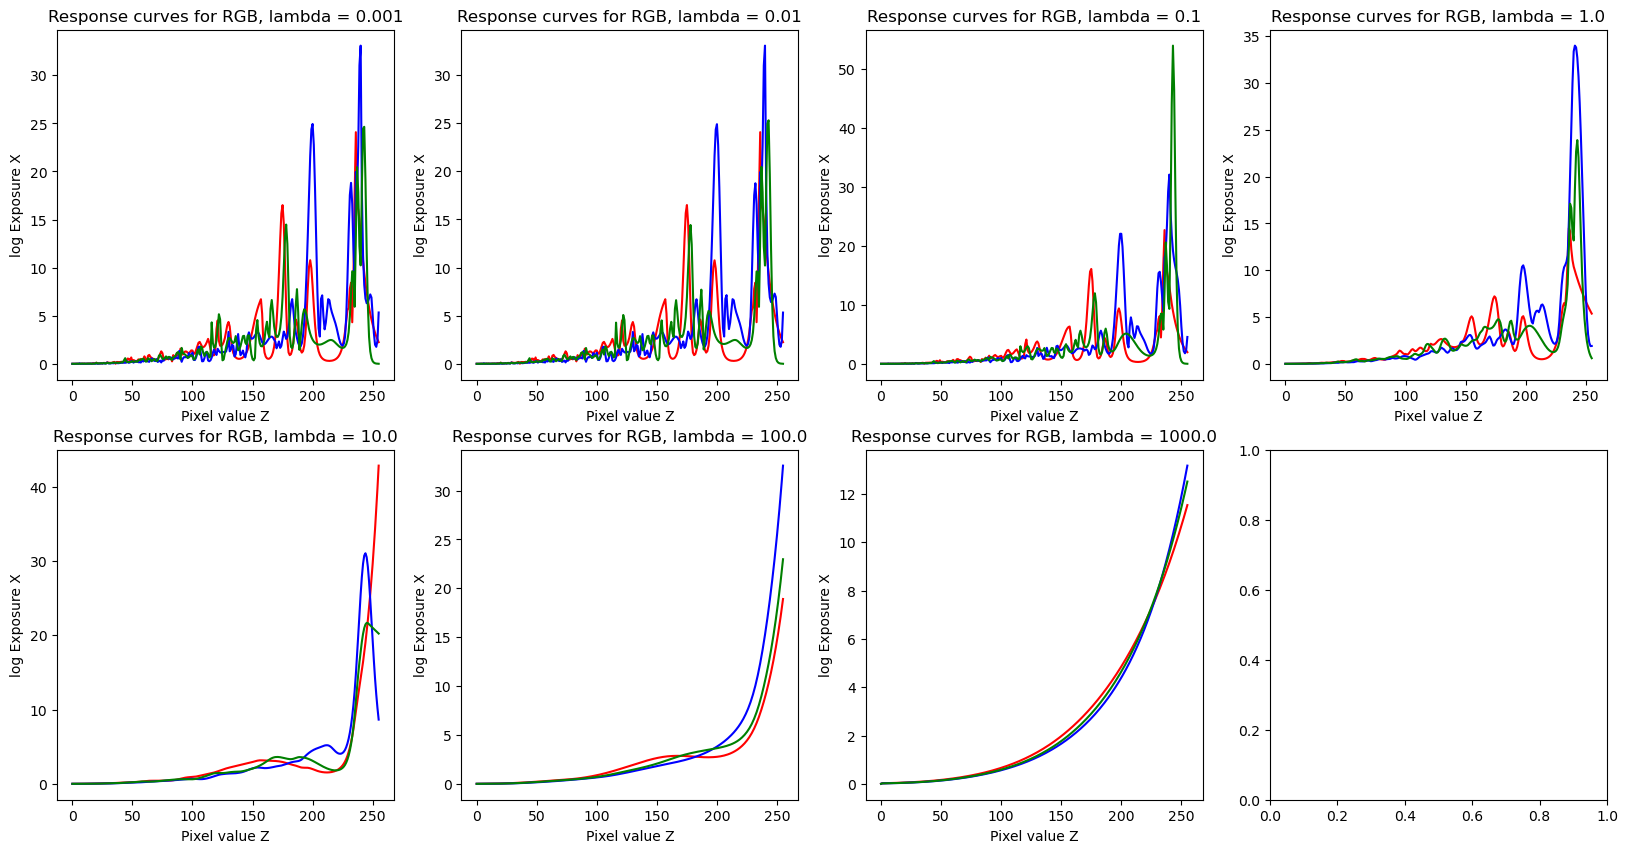

In [76]:
fig, axs = plt.subplots(2,4, figsize = (20, 10))
for i, l in enumerate(lambdas):
    crf = CameraRespFunct(path, l, exposures)
    g_list, lE_list = crf.getCameraResp()
    r = i // 4
    c = i % 4
    crf.plotResponseCurves(axs, r, c)

In [67]:
(crf.gB[crf.flattenedImages[1,2]] - np.log(crf.times[1])).shape

(12192768,)

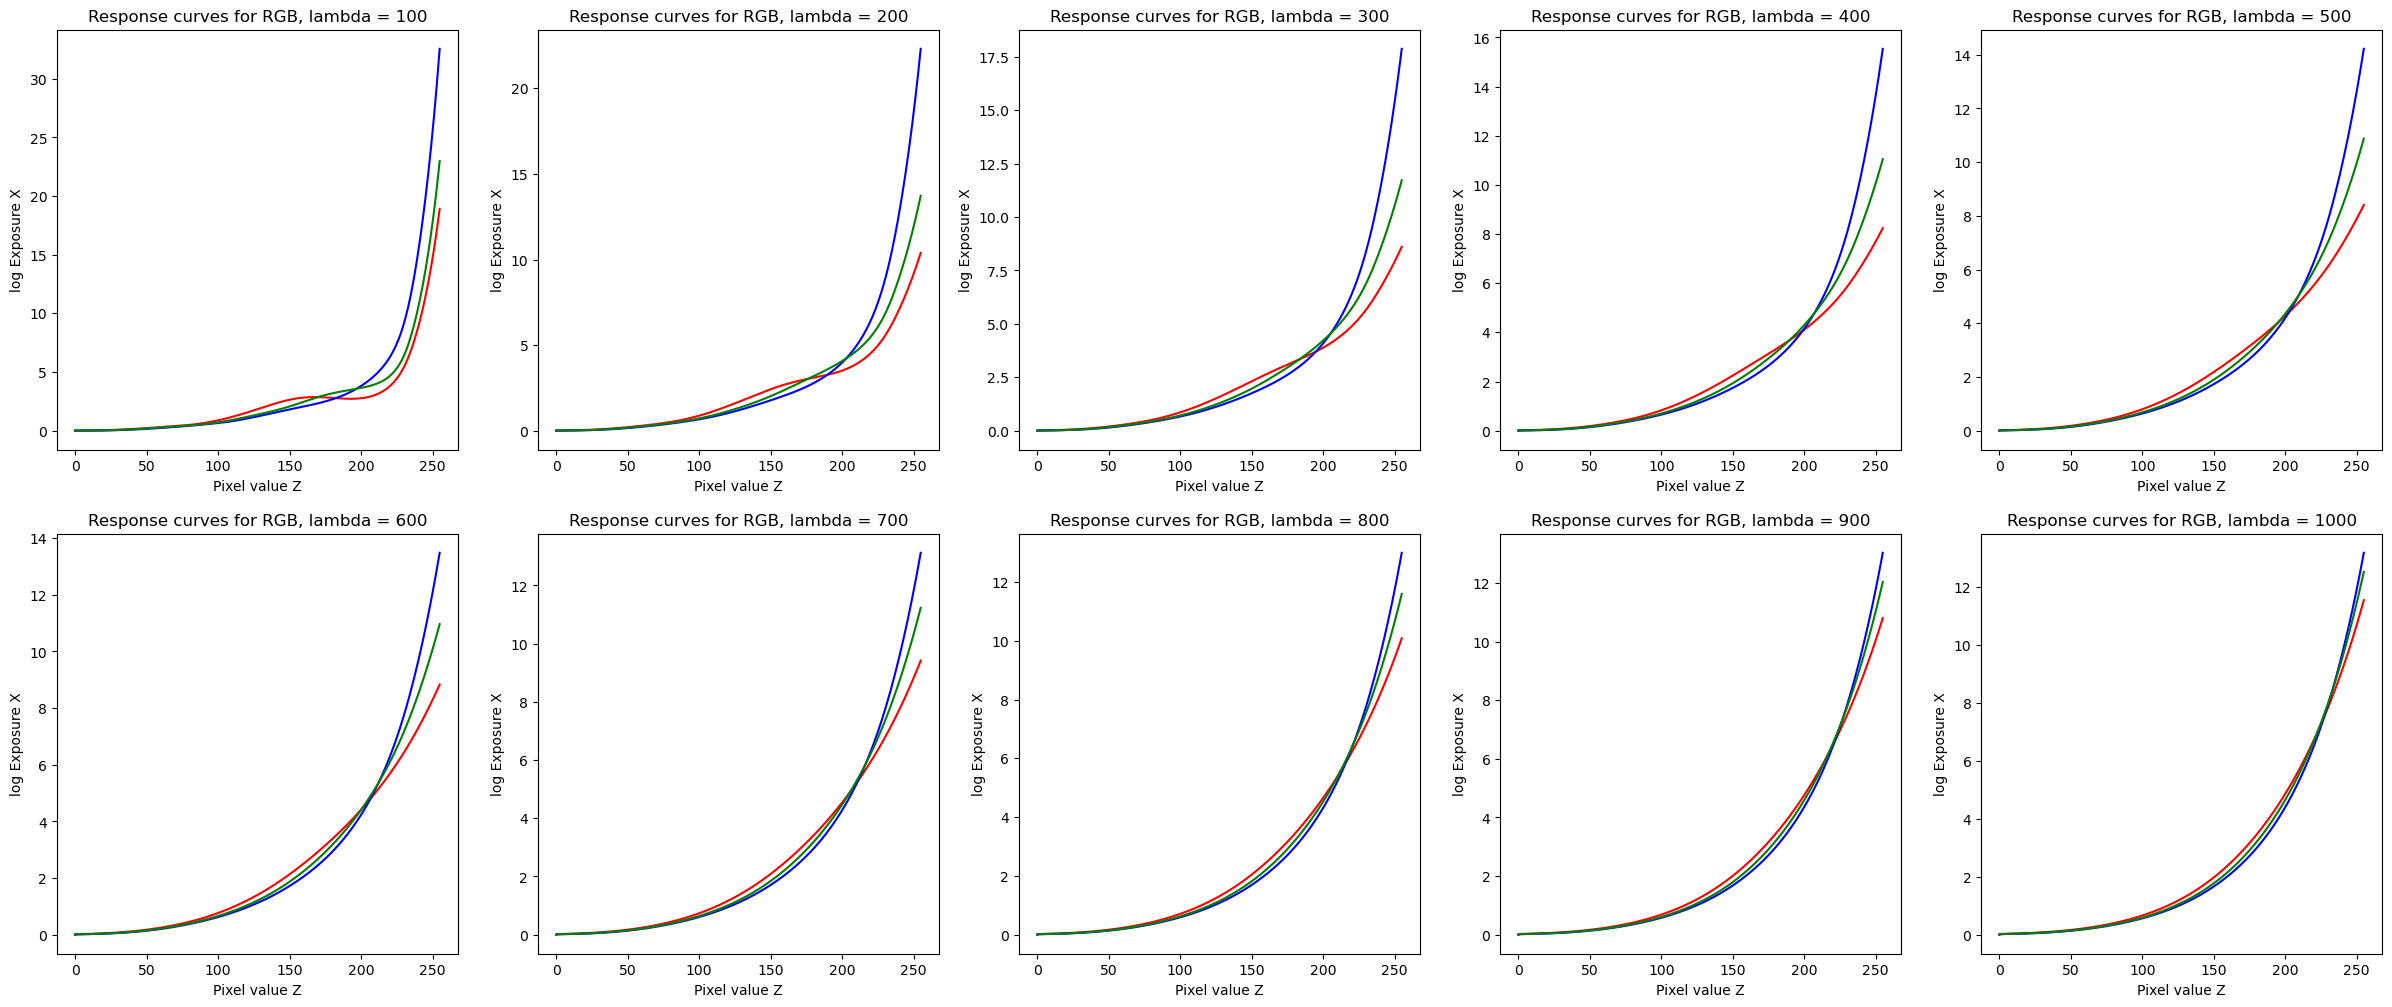

In [77]:
lambdas = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
fig, axs = plt.subplots(2,5, figsize = (30, 12))
for i, l in enumerate(lambdas):
    crf = CameraRespFunct(path, l, exposures)
    g_list, le_list = crf.getCameraResp()
    r = i // 5
    c = i % 5
    crf.plotResponseCurves(axs, r, c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


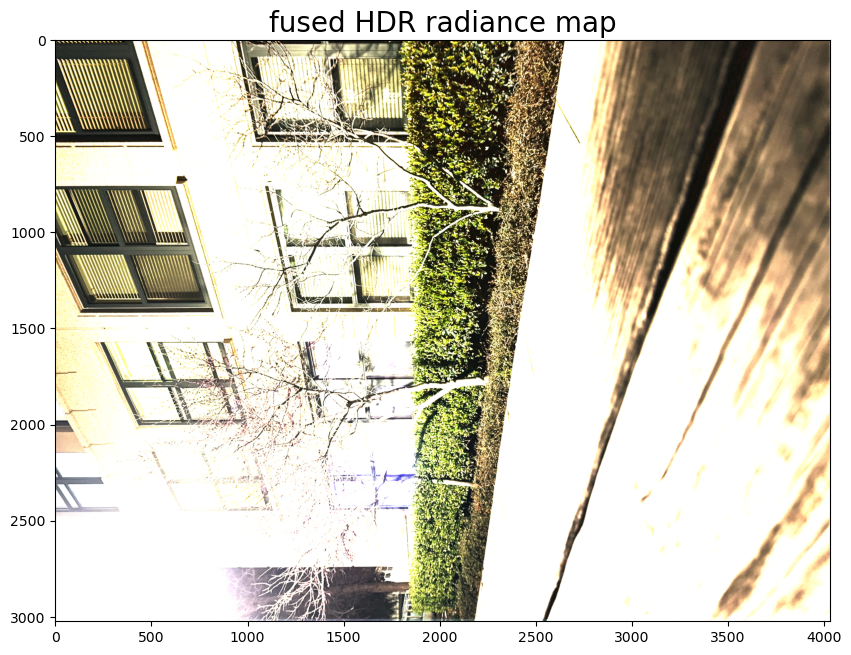

In [78]:
crf.recover_HDR_RadianceMap()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


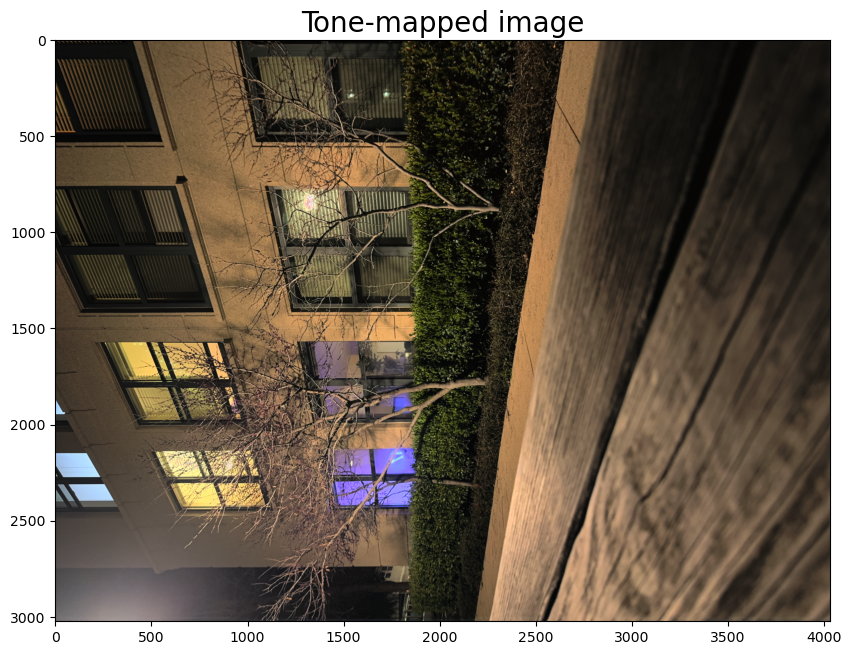

In [79]:
crf.tone_mapping()

In [12]:
l = {}


In [13]:
pixelToRAW_dict_R = {}
pixelToRAW_dict_G = {}
pixelToRAW_dict_B = {}

px = list(range(0,256))
for i, pixelVal in enumerate(px):
    pixelToRAW_dict_R[pixelVal] = g_list[0][i]
    pixelToRAW_dict_G[pixelVal] = g_list[1][i]
    pixelToRAW_dict_B[pixelVal] = g_list[2][i]

In [14]:
image_list = [] 
        
for i, filename in enumerate(glob.glob(path + "\\" + '*.jpg')): 
    im = cv2.imread(path + '\\' + str(i) + '.jpg')
    image_list.append(im)


In [16]:
len(image_list)
image_list[0].shape

(3024, 4032, 3)

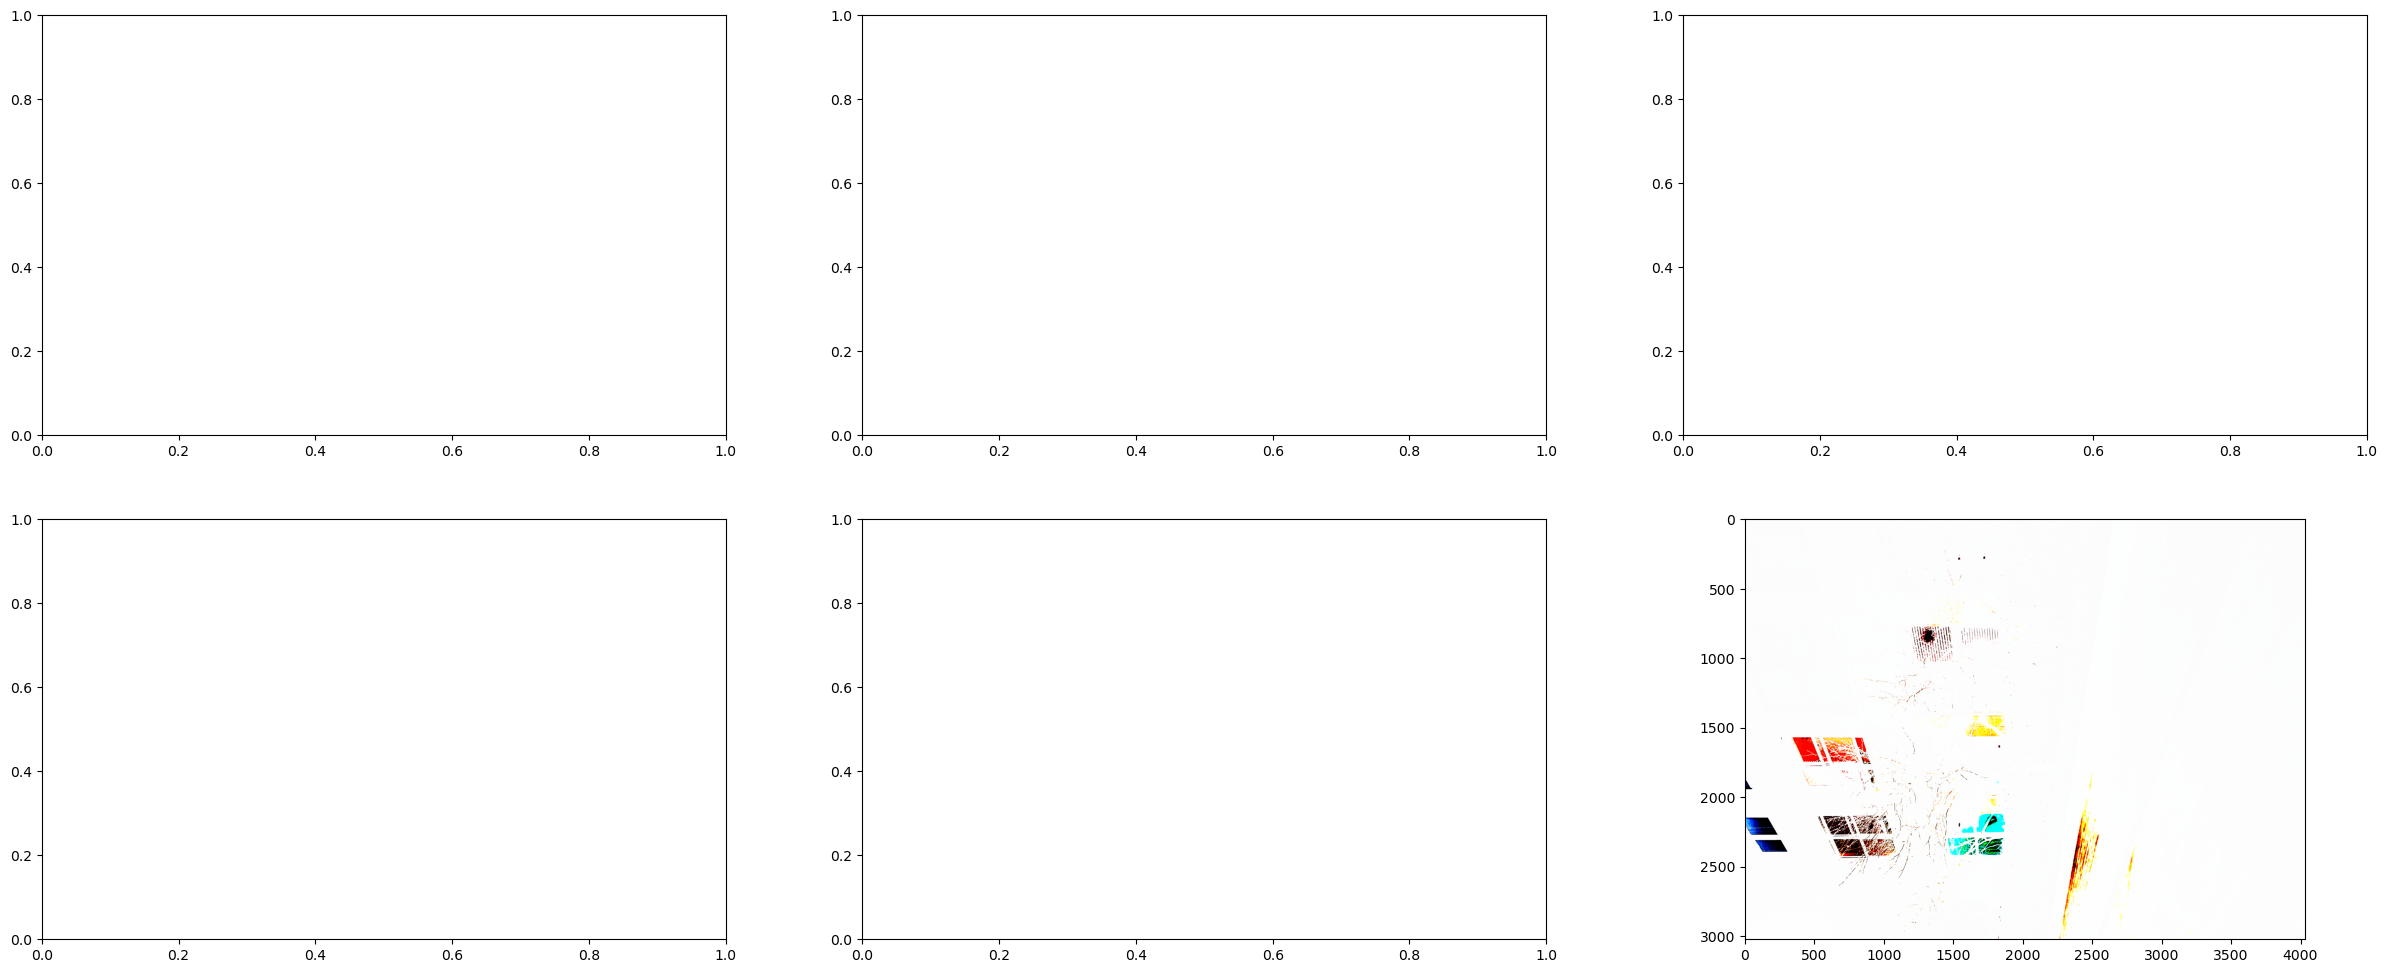

In [18]:
fig, axs = plt.subplots(2,3, figsize = (30, 12))
for i in range(len(image_list)):
    currImg = image_list[i]
    newImg = np.zeros_like(image_list[i])
    imgShape = newImg.shape
    for ch in range(imgShape[2]):
        for r in range(imgShape[0]):
            for c in range(imgShape[1]):
                if ch == 0: 
                    newImg[r, c, ch] = pixelToRAW_dict_R[currImg[r,c, ch]]
                elif ch == 1:
                    newImg[r, c, ch] = pixelToRAW_dict_G[currImg[r,c, ch]]
                else:
                    newImg[r, c, ch] = pixelToRAW_dict_B[currImg[r,c, ch]]
    row = i // 3
    col = i % 3
    axs[row, col] = plt.imshow(newImg)


#### HDR Pipeline

In [51]:
class PostProcess(CameraRespFunct):
    def __init__(self, CameraRespFunct):
        super(PostProcess, self).__init__(path, l, exposures)

    def recover_HDR_RadianceMap(self):
        m = np.zeros((self.flattenedImages.shape[1:]))
        wsum = np.zeros(self.flattenedImages.shape[1:])
        hdr = np.zeros(self.flattenedImages.shape[1:])
        
        lnDt = np.log(self.times)

        for i in range(self.N):

            wij_B = self.w_funct(self.flattenedImages[i,2])
            wij_G = self.w_funct(self.flattenedImages[i,1])
            wij_R = self.w_funct(self.flattenedImages[i,0])
            
            wsum[2,:] += wij_B
            wsum[1,:] += wij_G
            wsum[0,:] += wij_R
            
            m0 = np.subtract(self.gB[self.flattenedImages[i,2]],lnDt[i])[:,0]
            m1 = np.subtract(self.gG[self.flattenedImages[i,1]],lnDt[i])[:,0]
            m2 = np.subtract(self.gR[self.flattenedImages[i,0]],lnDt[i])[:,0]
    
            hdr[2] = hdr[2] + np.multiply(m0,wij_B)
            hdr[1] = hdr[1] + np.multiply(m1,wij_G)
            hdr[0] = hdr[0] + np.multiply(m2,wij_R)

        hdr = np.divide(hdr,wsum)
        hdr = np.exp(hdr)
        hdr = np.reshape(np.transpose(hdr), (self.H,self.W,3))
                    
        self.imgf32 = (hdr/np.amax(hdr)*255).astype(np.float32)
        plt.figure(constrained_layout=False,figsize=(10,10))
        plt.title("fused HDR radiance map", fontsize=20)
        plt.imshow(cv2.cvtColor(self.imgf32,cv2.COLOR_BGR2RGB))        

        

    def tone_mapping(self):
        # Tonemap using Drago's method to obtain 24-bit color image
        tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
        ldrDrago = tonemapDrago.process(self.imgf32)
        ldrDrago = 3 * ldrDrago
        cv2.imwrite("ldr-Drago-2.jpg", ldrDrago * 255)
        fig = plt.figure(constrained_layout=False,figsize=(10,10))
        plt.title("Tone-mapped image", fontsize=20)
        plt.imshow(cv2.cvtColor(ldrDrago, cv2.COLOR_BGR2RGB))

In [49]:
crf.flattenedImages

array([[[ 27,  36,  35, ..., 224, 224, 225],
        [ 52,  59,  56, ..., 237, 237, 238],
        [ 54,  61,  58, ..., 235, 235, 236]],

       [[ 16,   0,   0, ...,  86,  84,  94],
        [ 35,  15,   6, ..., 105, 103, 113],
        [ 38,  18,   9, ..., 120, 118, 128]],

       [[  2,   3,   5, ...,  66,  77,  78],
        [ 15,  16,  14, ...,  83,  94,  95],
        [ 17,  18,  17, ...,  96, 107, 108]],

       [[  0,   5,   3, ...,  57,  44,  43],
        [  2,  10,   8, ...,  69,  56,  55],
        [  3,  11,   9, ...,  79,  66,  65]],

       [[  0,   1,   1, ...,  24,  29,  39],
        [  5,   9,   9, ...,  32,  37,  47],
        [  4,   8,   8, ...,  39,  44,  54]],

       [[  1,   0,   0, ...,  32,  32,  21],
        [  3,   2,   1, ...,  38,  38,  27],
        [  3,   2,   1, ...,  43,  43,  32]]], dtype=uint8)

In [52]:
hdr = PostProcess(crf)
hdr.recover_HDR_RadianceMap()

AttributeError: 'PostProcess' object has no attribute 'flattenedImages'